In [1]:
import sys
sys.path.append('../input')
print(sys.path)

import os
import keras
import torch
import warnings
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, matthews_corrcoef
warnings.filterwarnings("ignore")

['/kaggle/working', '/kaggle/lib/kagglegym', '/kaggle/lib', '/opt/conda/lib/python310.zip', '/opt/conda/lib/python3.10', '/opt/conda/lib/python3.10/lib-dynload', '', '/root/.local/lib/python3.10/site-packages', '/opt/conda/lib/python3.10/site-packages', '/root/src/BigQuery_Helper', '../input']


2024-03-23 12:00:02.501380: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-23 12:00:02.501481: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-23 12:00:02.628798: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
torch.cuda.is_available()

True

In [3]:
# 使用GPU加速运算
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [4]:
# 读取数据并预处理
species_data = []
species_labels = []

data_folder = "/kaggle/input/dna-sequence/DNA_sequence"
files = ["chimpanzee.txt", "dog.txt", "human.txt"]


In [5]:
for file in files:
    file_path = os.path.join(data_folder, file)
    with open(file_path, "r") as f:
        # 跳过标题行,也就是首行
        next(f)
        for line in f:
            sequence = line.split()[0]
            species_data.append(sequence)
            species_labels.append(file.split(".")[0])


In [6]:
# 划分数据，原始数据为5000
train_sz = (5000.0/len(species_data))
sequences, _sequences, class_label, _class_label = train_test_split(
    species_data, species_labels, train_size=train_sz, random_state=42, stratify=species_labels)

X_train_val, X_test, y_train_val, y_test = train_test_split(sequences, class_label, test_size=0.2, random_state=42,
                                                            stratify=class_label)# 将标签编码为数字
label_mapping = {"chimpanzee": 0, "dog": 1, "human": 2}
species_labels_encoded = [label_mapping[label] for label in species_labels]

# 划分数据
train_sz = (500.0/len(species_data))
sequences, _sequences, class_label, _class_label = train_test_split(
    species_data, species_labels_encoded, train_size=train_sz, random_state=42, stratify=species_labels_encoded)

X_train_val, X_test, y_train_val, y_test = train_test_split(sequences, class_label, test_size=0.2, random_state=42,
                                                            stratify=class_label)

In [7]:
class SeqEmbedding():
    def __init__(self):
        self.Dictionary = {}

    def __Sequence_to_Numeric(self, k, sequence):
        if k == 0:
            temp = [0] * self.size_of_vector
            temp[len(self.Dictionary)] = 1
            self.Dictionary[sequence] = temp
            return
        nucleotide = ['A', 'C', 'G', 'T']
        for n in nucleotide:
            self.__Sequence_to_Numeric(k - 1, sequence + n)
        return

    def fit(self, sequences, window_size, stride_size):
        self.size_of_vector = 4 ** window_size
        self.__Sequence_to_Numeric(window_size, "")

        vectorized = []

        for seq in sequences:
            first_layer_embedding = []
            for k in range(window_size, len(seq) + 1, stride_size):
                try:
                    first_layer_embedding.append(self.Dictionary[seq[k - window_size:k]])
                except:
                    # exception may occur because of stride size, sometimes it may not get sequence of length window
                    # size, there will be a key not found exception in Dictionary
                    first_layer_embedding.append([0] * self.size_of_vector)

            vector0 = []
            vector1 = []
            for i in range(len(first_layer_embedding)):
                if i > 0:
                    vector1 += first_layer_embedding[i]
                vector0 += first_layer_embedding[i]
            vector1 += first_layer_embedding[0]

            vectorized.append([vector0, vector1])

        # Handling inequal length problem using zero padding
        max_len = 0
        for vec in vectorized:
            max_len = max(max_len, len(vec[0]))
        for i in range(len(vectorized)):
            required = max_len - len(vectorized[i][0])

            vectorized[i][0] += ([0] * required)
            vectorized[i][0] = vectorized[i][0][:31752]  # to fit into 252 * 252 pixel size, removing 120 elements
            vectorized[i][0] = np.array(vectorized[i][0])

            vectorized[i][1] += ([0] * required)
            vectorized[i][1] = vectorized[i][1][:31752]  # to fit into 252 * 252 pixel size, removing 120 elements
            vectorized[i][1] = np.array(vectorized[i][1])

            vectorized[i] = np.array(vectorized[i])

        return np.array(vectorized)


instance = SeqEmbedding()
X_train_val = instance.fit(sequences=X_train_val, window_size=3, stride_size=1)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42,
                                                  stratify=y_train_val)
# 观察输入数据形状格式是否正确
print(X_train.shape)

(360, 2, 31752)


In [8]:
# 转化类型适应CPU和GPU处理
X_train = torch.tensor(X_train).to(device)
X_val = torch.tensor(X_val).to(device)

y_train = torch.tensor(y_train).to(device)
y_val = torch.tensor(y_val).to(device)


In [9]:
X_train = X_train.reshape(X_train.shape[0],252, 252, 1)
X_val = X_val.reshape(X_val.shape[0], 252, 252, 1)

In [10]:
ins = SeqEmbedding()
X_test = ins.fit(sequences=X_test,window_size = 3, stride_size = 1)

In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(252, 252, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.summary()

model.compile(optimizer='sgd',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy',mode='max',verbose=1,patience=200)
mc = ModelCheckpoint('best_model.h5.keras',monitor='val_accuracy',mode='max',verbose=1,save_best_only=True)

# 　原epochs=300,batch_size=512
hist = model.fit(X_train,y_train, validation_data=(X_val,y_val), epochs=300,batch_size=512,callbacks=[es,mc])



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 250, 250, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 125, 125, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 123, 123, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 61, 61, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 59536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     5,953,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,956,382 (22.72 MB)

 Trainable params: 5,956,382 (22.72 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300


2024-03-23 12:00:32.144682: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[360,16,250,250]{3,2,1,0}, u8[0]{0}) custom-call(f32[360,1,252,252]{3,2,1,0}, f32[16,1,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-03-23 12:00:33.661696: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.21048, expected 1.66744
2024-03-23 12:00:33.661753: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.48688, expected 1.94383
2024-03-23 12:00:33.661763: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.12015, expected 1.57711
2024-03-23 12:00:33.661771: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - accuracy: 0.2000 - loss: nan

I0000 00:00:1711195255.846912      85 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711195255.865620      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-03-23 12:00:56.594891: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 62540: 1.67168, expected 1.39857
2024-03-23 12:00:56.594949: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 62576: 1.51956, expected 1.24646
2024-03-23 12:00:56.594959: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 62789: 1.62441, expected 1.3513
2024-03-23 12:00:56.594976: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 62844: 1.63149, expected 1.35838
2024-03-23 12:00:56.594993: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 63217: 1.57658, expected 1.30348
2024-03-23 12:00:56.59500


Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to best_model.h5.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 30s 30s/step - accuracy: 0.2000 - loss: nan - val_accuracy: 0.1250 - val_loss: nan
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.1194 - loss: nan
Epoch 2: val_accuracy did not improve from 0.12500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.1194 - loss: nan - val_accuracy: 0.1250 - val_loss: nan
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.1194 - loss: nan
Epoch 3: val_accuracy did not improve from 0.12500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.1194 - loss: nan - val_accuracy: 0.1250 - val_loss: nan
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.1194 - loss: nan
Epoch 4: val_accuracy did not improve from 0.12500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.1194 - loss: nan - val_accuracy: 0.1250 - val_loss: nan
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.1194 - loss

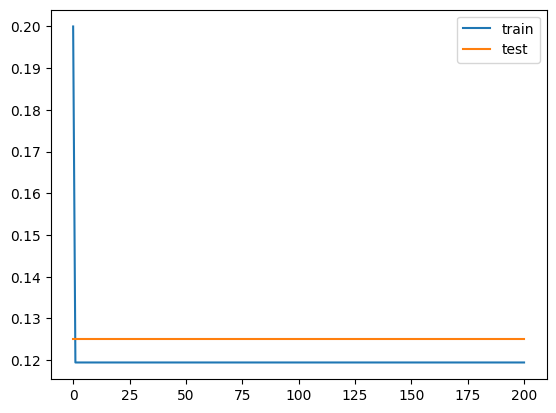

In [12]:
plt.plot(hist.history['accuracy'],label='train')
plt.plot(hist.history['val_accuracy'],label='test')
plt.legend()
plt.show()

In [16]:
# import pickle as pkl
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(252,252,1)),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Conv2D(16,(3,3),activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(100,activation='relu'),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(2,activation='softmax')
])
model.compile(optimizer='sgd',loss='sparse_categorical_crossentropy',metrics=['accuracy'])


In [18]:

strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")  # 指定在第一个 GPU 上运行模型

epochs = 10
batch_size = 360

with strategy.scope():
    model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=200)
    mc = ModelCheckpoint('best_model.weights.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True, save_weights_only=True)

    for epoch in tqdm(range(epochs), desc="Epochs"):
        # 训练循环代码
         for batch in tqdm(range(0, len(X_train), batch_size), desc="Batches", leave=False):
                
                X_batch = X_train[batch:batch+batch_size].cpu().numpy()  # 将X_batch从CUDA设备复制到主机内存并转换为NumPy数组
                y_batch = y_train[batch:batch+batch_size].cpu().numpy()  # 将y_batch从CUDA设备复制到主机内存并转换为NumPy数组
                model.train_on_batch(X_batch, y_batch)

                # Validation
                val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
                tqdm.write(f"Epoch {epoch+1}/{epochs} - val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}")

                # Early stopping
                es.on_epoch_end(epoch, logs={"val_accuracy": val_acc})

                # Model checkpoint
                if es.stopped_epoch == epoch:
                    model_to_save = tf.keras.models.Sequential([
                        tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(252, 252, 1)),
                        tf.keras.layers.MaxPooling2D(2, 2),
                        tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
                        tf.keras.layers.MaxPooling2D(2, 2),
                        tf.keras.layers.Flatten(),
                        tf.keras.layers.Dense(100, activation='relu'),
                        tf.keras.layers.Dropout(0.5),
                        tf.keras.layers.Dense(2, activation='softmax')
                    ])

                    break


Batches:   0%|          | 0/1 [00:00<?, ?it/s]W0000 00:00:1711195459.686010      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-03-23 12:04:20.451405: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.47294, expected 2.10939
2024-03-23 12:04:20.451477: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.41328, expected 2.04973
2024-03-23 12:04:20.451488: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 2.62018, expected 2.25663
2024-03-23 12:04:20.451498: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 2.49895, expected 2.1354
2024-03-23 12:04:20.451506: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 2.33992, expected 1.97637
2024-03-23 12:04:20.451515: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10: 2.44382, expected 2.08027
2024-03-23 12:04:20

Epoch 1/10 - val_loss: nan - val_acc: 0.1250



                                                      
Epochs:  20%|██        | 2/10 [00:37<02:28, 18.53s/it]

Epoch 2/10 - val_loss: nan - val_acc: 0.1250



                                                      
Epochs:  30%|███       | 3/10 [00:54<02:03, 17.64s/it]

Epoch 3/10 - val_loss: nan - val_acc: 0.1250



                                                      
Epochs:  40%|████      | 4/10 [01:10<01:42, 17.16s/it]

Epoch 4/10 - val_loss: nan - val_acc: 0.1250



                                                      
Epochs:  50%|█████     | 5/10 [01:27<01:24, 16.95s/it]

Epoch 5/10 - val_loss: nan - val_acc: 0.1250



                                                      
Epochs:  60%|██████    | 6/10 [01:43<01:07, 16.79s/it]

Epoch 6/10 - val_loss: nan - val_acc: 0.1250



                                                      
Epochs:  70%|███████   | 7/10 [02:00<00:49, 16.66s/it]

Epoch 7/10 - val_loss: nan - val_acc: 0.1250



                                                      
Epochs:  80%|████████  | 8/10 [02:16<00:33, 16.56s/it]

Epoch 8/10 - val_loss: nan - val_acc: 0.1250



                                                      
Epochs:  90%|█████████ | 9/10 [02:32<00:16, 16.49s/it]

Epoch 9/10 - val_loss: nan - val_acc: 0.1250



                                                      
Epochs: 100%|██████████| 10/10 [02:49<00:00, 16.92s/it][A

Epoch 10/10 - val_loss: nan - val_acc: 0.1250
